# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [1]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [2]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
(ds_train, ds_val) = torch.utils.data.random_split(ds_train, (len(ds_train)-val_size, val_size))


100%|██████████| 9912422/9912422 [00:00<00:00, 83936056.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 83599512.65it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22743059.23it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18495659.00it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
#FastDataloader

class _RepeatSampler(object):

    def __init__(self, sampler):
        self.sampler = sampler

    def __iter__(self):
        while True:
            yield from iter(self.sampler)

class FastDataloader(torch.utils.data.DataLoader):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        object.__setattr__(self, 'batch_sampler', _RepeatSampler(self.batch_sampler))
        self.iterator = super().__iter__()

    def __len__(self):
        return len(self.batch_sampler.sampler)

    def __iter__(self):
        for i in range(len(self)):
            yield next(self.iterator)



>FastDataloader is useful for Windows and lets us reuse workers and make the loading of data quicker. [Source](https://github.com/pytorch/pytorch/issues/15849)

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [4]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=143de85450e1a36ad15d44dd93cd4735adfce560fe48e7536ba0682a3651477a
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [5]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [33]:
#TRAINING PIPELINE

from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()


def train_epoch(model, train_loader, opt, epoch='Unknown', device='cpu'):
    model.train()
    train_losses = []
    correct_train = 0
    for (images, labels) in tqdm(train_loader, desc=f'Training epoch {epoch}', leave=True):
        opt.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        preds = model(images)
        preds = preds.flatten(1) #for the last exercise
        labels = labels.flatten(1)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(preds,  labels)
        loss.backward()
        opt.step()
        train_losses.append(loss.item())
        correct_train += get_num_correct(preds,  labels)

    train_metrics = {"train_loss": np.mean(train_losses),
               "train_acc": correct_train/len(ds_train)}
    print(f'Accuracy(test): {correct_train}/{len(ds_train)}')
    print(f'Mean Loss: {np.mean(train_losses)}')
    wandb.log(train_metrics)
    return (np.mean(train_losses), correct_train)

    #We return the values but we also load them into wandb


def testing_epoch(model, testing_loader, ds_len=len(ds_val), device='cpu'):
  correct = 0
  losses = []
  model.eval()
  with torch.no_grad():
    for batch in testing_loader:
      images, labels = batch
      images = images.to(device)
      labels = labels.to(device)
      preds = model(images)
      preds = preds.flatten(1) #for the last exercise
      labels = labels.flatten(1)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(preds,  labels)
      correct += get_num_correct(preds,  labels)
      losses.append(loss.item())
    print(f'Accuracy(val): {correct}/{ds_len} / Mean Loss: {np.mean(losses)}')
    print(f'Mean Loss: {np.mean(losses)}')
    val_metrics={"val_loss":np.mean(losses), "val_acc":correct/ds_len}
    #wandb.log(val_metrics)
    return (np.mean(losses), correct)


#Training loop over all epochs
def training(model, train_loader, val_loader, opt, num_epochs, device, ds_len=len(ds_val)):
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []
  for epoch in range(num_epochs):
    train_loss, acc_train = train_epoch(model, train_loader, opt, epoch=epoch, device=device)
    val_loss, acc_val = testing_epoch(model, val_loader, ds_len, device=device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(acc_train/len(ds_train))
    val_accs.append(acc_val/ds_len)

  return train_losses, val_losses, train_accs, val_accs


def plot_validation_curves(train_losses, val_losses, train_accs, val_accs):
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot([l for l in train_losses], label='Train set')
  plt.plot([l for l in val_losses], label='Validation set')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Average Loss per Epoch')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot([a for a in train_accs], label='Train Accuracy')
  plt.plot([a for a in val_accs], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.legend()
  plt.show()


# MLP

In [ ]:
#MODEL DEFINITION

class MLP(nn.Module):
  def __init__(self, input_size, width, depth, num_classes):
    super().__init__()
    self.depth = depth
    self.fc1 = nn.Linear(input_size, width)
    self.d = nn.Linear(width, width)
    self.output = nn.Linear(width, num_classes)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x.view(len(x), -1)))
    for d in range(2, self.depth+1):
      x = self.relu(self.d(x))
    x = self.output(x)
    return x

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_theme()

> In this first exercise, we train and test our MLP model on the MNIST dataset. We can run the cell below as many times as we want changing the parameter `depth` and see the results on the WandB page. I used d = [1, 2, 10, 30].
The depth of the model refers to the number of hidden layers; for our model simple fully connected layers with the same number of nodes in input and output.

Currently using cuda


Training epoch 0: 100%|██████████| 215/215 [00:12<00:00, 17.07it/s]


Accuracy(test): 45566/55000 / Mean Loss: 0.6050252157588337
Accuracy(val): 4533/5000 / Mean Loss: 0.3282011568546295
 


Training epoch 1: 100%|██████████| 215/215 [00:12<00:00, 17.58it/s]


Accuracy(test): 50319/55000 / Mean Loss: 0.29387270621089046
Accuracy(val): 4581/5000 / Mean Loss: 0.28245143592357635
 


Training epoch 2: 100%|██████████| 215/215 [00:12<00:00, 17.58it/s]


Accuracy(test): 50881/55000 / Mean Loss: 0.26033625873022304
Accuracy(val): 4606/5000 / Mean Loss: 0.25818365886807443
 


Training epoch 3: 100%|██████████| 215/215 [00:14<00:00, 14.92it/s]


Accuracy(test): 51273/55000 / Mean Loss: 0.23786641525667768
Accuracy(val): 4650/5000 / Mean Loss: 0.2372829422354698
 


Training epoch 4: 100%|██████████| 215/215 [00:12<00:00, 17.55it/s]


Accuracy(test): 51523/55000 / Mean Loss: 0.2204685562571814
Accuracy(val): 4675/5000 / Mean Loss: 0.22233582139015198
 


Training epoch 5: 100%|██████████| 215/215 [00:11<00:00, 19.44it/s]


Accuracy(test): 51722/55000 / Mean Loss: 0.2070454720494359
Accuracy(val): 4695/5000 / Mean Loss: 0.21171267032623292
 


Training epoch 6: 100%|██████████| 215/215 [00:10<00:00, 19.69it/s]


Accuracy(test): 51911/55000 / Mean Loss: 0.1934627223153447
Accuracy(val): 4716/5000 / Mean Loss: 0.20229212902486324
 


Training epoch 7: 100%|██████████| 215/215 [00:11<00:00, 17.95it/s]


Accuracy(test): 52063/55000 / Mean Loss: 0.18538717104251995
Accuracy(val): 4709/5000 / Mean Loss: 0.19820054136216642
 


Training epoch 8: 100%|██████████| 215/215 [00:12<00:00, 17.71it/s]


Accuracy(test): 52182/55000 / Mean Loss: 0.17641862131828487
Accuracy(val): 4720/5000 / Mean Loss: 0.19119887836277485
 


Training epoch 9: 100%|██████████| 215/215 [00:12<00:00, 17.55it/s]


Accuracy(test): 52257/55000 / Mean Loss: 0.1710844648092292
Accuracy(val): 4723/5000 / Mean Loss: 0.18724290803074836
 


Training epoch 10: 100%|██████████| 215/215 [00:13<00:00, 15.78it/s]


Accuracy(test): 52368/55000 / Mean Loss: 0.1645449669901715
Accuracy(val): 4739/5000 / Mean Loss: 0.18048711381852628
 


Training epoch 11: 100%|██████████| 215/215 [00:12<00:00, 17.68it/s]


Accuracy(test): 52458/55000 / Mean Loss: 0.15943754849045777
Accuracy(val): 4743/5000 / Mean Loss: 0.18044875115156173
 


Training epoch 12: 100%|██████████| 215/215 [00:12<00:00, 17.43it/s]


Accuracy(test): 52483/55000 / Mean Loss: 0.1555353198980176
Accuracy(val): 4744/5000 / Mean Loss: 0.17825684063136576
 


Training epoch 13: 100%|██████████| 215/215 [00:11<00:00, 18.76it/s]


Accuracy(test): 52599/55000 / Mean Loss: 0.15091079282899236
Accuracy(val): 4749/5000 / Mean Loss: 0.17710429877042771
 


Training epoch 14: 100%|██████████| 215/215 [00:10<00:00, 20.27it/s]


Accuracy(test): 52642/55000 / Mean Loss: 0.14818657761396364
Accuracy(val): 4760/5000 / Mean Loss: 0.17541067935526372
 


Training epoch 15: 100%|██████████| 215/215 [00:10<00:00, 19.67it/s]


Accuracy(test): 52655/55000 / Mean Loss: 0.14408367549957232
Accuracy(val): 4746/5000 / Mean Loss: 0.17756743989884854
 


Training epoch 16: 100%|██████████| 215/215 [00:14<00:00, 15.23it/s]


Accuracy(test): 52704/55000 / Mean Loss: 0.14085747720890268
Accuracy(val): 4776/5000 / Mean Loss: 0.17129086293280124
 


Training epoch 17: 100%|██████████| 215/215 [00:12<00:00, 16.58it/s]


Accuracy(test): 52798/55000 / Mean Loss: 0.13786203478311385
Accuracy(val): 4762/5000 / Mean Loss: 0.17423706278204917
 


Training epoch 18: 100%|██████████| 215/215 [00:12<00:00, 17.35it/s]


Accuracy(test): 52829/55000 / Mean Loss: 0.13503227147252062
Accuracy(val): 4763/5000 / Mean Loss: 0.1667057268321514
 


Training epoch 19: 100%|██████████| 215/215 [00:12<00:00, 17.30it/s]


Accuracy(test): 52860/55000 / Mean Loss: 0.13287475686087163
Accuracy(val): 4765/5000 / Mean Loss: 0.1702872198075056
 


Training epoch 20: 100%|██████████| 215/215 [00:12<00:00, 17.51it/s]


Accuracy(test): 52869/55000 / Mean Loss: 0.13076829912011015
Accuracy(val): 4757/5000 / Mean Loss: 0.1687371965497732
 


Training epoch 21: 100%|██████████| 215/215 [00:12<00:00, 17.28it/s]


Accuracy(test): 52933/55000 / Mean Loss: 0.12824674413301224
Accuracy(val): 4761/5000 / Mean Loss: 0.16844687312841417
 


Training epoch 22: 100%|██████████| 215/215 [00:14<00:00, 14.90it/s]


Accuracy(test): 52971/55000 / Mean Loss: 0.1261543303901373
Accuracy(val): 4753/5000 / Mean Loss: 0.16570018157362937
 


Training epoch 23: 100%|██████████| 215/215 [00:11<00:00, 18.56it/s]


Accuracy(test): 52979/55000 / Mean Loss: 0.12396222649272098
Accuracy(val): 4770/5000 / Mean Loss: 0.17053597122430803
 


Training epoch 24: 100%|██████████| 215/215 [00:10<00:00, 19.99it/s]


Accuracy(test): 53034/55000 / Mean Loss: 0.12232033100932144
Accuracy(val): 4777/5000 / Mean Loss: 0.16360197998583317
 


Training epoch 25: 100%|██████████| 215/215 [00:11<00:00, 18.93it/s]


Accuracy(test): 53040/55000 / Mean Loss: 0.12063800138096477
Accuracy(val): 4772/5000 / Mean Loss: 0.1677079200744629
 


Training epoch 26: 100%|██████████| 215/215 [00:12<00:00, 17.46it/s]


Accuracy(test): 53088/55000 / Mean Loss: 0.11966159811546637
Accuracy(val): 4773/5000 / Mean Loss: 0.16251753494143487
 


Training epoch 27: 100%|██████████| 215/215 [00:12<00:00, 17.37it/s]


Accuracy(test): 53074/55000 / Mean Loss: 0.11761068573524786
Accuracy(val): 4779/5000 / Mean Loss: 0.16442832052707673
 


Training epoch 28: 100%|██████████| 215/215 [00:13<00:00, 15.54it/s]


Accuracy(test): 53140/55000 / Mean Loss: 0.11543622819143673
Accuracy(val): 4780/5000 / Mean Loss: 0.1617389488965273
 


Training epoch 29: 100%|██████████| 215/215 [00:12<00:00, 17.57it/s]


Accuracy(test): 53134/55000 / Mean Loss: 0.11348607810430748
Accuracy(val): 4775/5000 / Mean Loss: 0.16315337605774402
 


Training epoch 30: 100%|██████████| 215/215 [00:12<00:00, 17.30it/s]


Accuracy(test): 53166/55000 / Mean Loss: 0.11253697854834933
Accuracy(val): 4771/5000 / Mean Loss: 0.16199678927659988
 


Training epoch 31: 100%|██████████| 215/215 [00:12<00:00, 17.61it/s]


Accuracy(test): 53197/55000 / Mean Loss: 0.11054105651240016
Accuracy(val): 4771/5000 / Mean Loss: 0.16418543197214602
 


Training epoch 32: 100%|██████████| 215/215 [00:12<00:00, 17.81it/s]


Accuracy(test): 53200/55000 / Mean Loss: 0.1096265818837077
Accuracy(val): 4766/5000 / Mean Loss: 0.1655119325965643
 


Training epoch 33: 100%|██████████| 215/215 [00:11<00:00, 19.11it/s]


Accuracy(test): 53217/55000 / Mean Loss: 0.10934627581994201
Accuracy(val): 4764/5000 / Mean Loss: 0.16143011450767517
 


Training epoch 34: 100%|██████████| 215/215 [00:11<00:00, 18.90it/s]


Accuracy(test): 53248/55000 / Mean Loss: 0.10740610484120458
Accuracy(val): 4763/5000 / Mean Loss: 0.16605811081826688
 


Training epoch 35: 100%|██████████| 215/215 [00:14<00:00, 15.00it/s]


Accuracy(test): 53265/55000 / Mean Loss: 0.10602953825579133
Accuracy(val): 4760/5000 / Mean Loss: 0.16819913797080516
 


Training epoch 36: 100%|██████████| 215/215 [00:12<00:00, 17.40it/s]


Accuracy(test): 53283/55000 / Mean Loss: 0.10514215710897779
Accuracy(val): 4764/5000 / Mean Loss: 0.1638344783335924
 


Training epoch 37: 100%|██████████| 215/215 [00:12<00:00, 17.47it/s]


Accuracy(test): 53273/55000 / Mean Loss: 0.10359648786658464
Accuracy(val): 4759/5000 / Mean Loss: 0.16565973944962026
 


Training epoch 38: 100%|██████████| 215/215 [00:12<00:00, 17.56it/s]


Accuracy(test): 53313/55000 / Mean Loss: 0.10239850008903548
Accuracy(val): 4757/5000 / Mean Loss: 0.1661392405629158
 


Training epoch 39: 100%|██████████| 215/215 [00:12<00:00, 17.27it/s]


Accuracy(test): 53362/55000 / Mean Loss: 0.10069109047221583
Accuracy(val): 4748/5000 / Mean Loss: 0.16690455414354802
 


Training epoch 40: 100%|██████████| 215/215 [00:11<00:00, 18.07it/s]


Accuracy(test): 53329/55000 / Mean Loss: 0.09986592720067779
Accuracy(val): 4767/5000 / Mean Loss: 0.16282967254519462
 


Training epoch 41: 100%|██████████| 215/215 [00:14<00:00, 15.33it/s]


Accuracy(test): 53381/55000 / Mean Loss: 0.1000977125278739
Accuracy(val): 4770/5000 / Mean Loss: 0.16378300711512567
 


Training epoch 42: 100%|██████████| 215/215 [00:11<00:00, 18.82it/s]


Accuracy(test): 53386/55000 / Mean Loss: 0.09742251960344092
Accuracy(val): 4758/5000 / Mean Loss: 0.16643418706953525
 


Training epoch 43: 100%|██████████| 215/215 [00:10<00:00, 20.02it/s]


Accuracy(test): 53417/55000 / Mean Loss: 0.09729767535315004
Accuracy(val): 4761/5000 / Mean Loss: 0.16419237330555916
 


Training epoch 44: 100%|██████████| 215/215 [00:11<00:00, 18.41it/s]


Accuracy(test): 53367/55000 / Mean Loss: 0.0975191340543503
Accuracy(val): 4770/5000 / Mean Loss: 0.16662127077579497
 


Training epoch 45: 100%|██████████| 215/215 [00:12<00:00, 17.44it/s]


Accuracy(test): 53418/55000 / Mean Loss: 0.09650960679837438
Accuracy(val): 4760/5000 / Mean Loss: 0.16629622355103493
 


Training epoch 46: 100%|██████████| 215/215 [00:12<00:00, 17.32it/s]


Accuracy(test): 53456/55000 / Mean Loss: 0.09425571746257848
Accuracy(val): 4759/5000 / Mean Loss: 0.17091860100626946
 


Training epoch 47: 100%|██████████| 215/215 [00:14<00:00, 14.91it/s]


Accuracy(test): 53438/55000 / Mean Loss: 0.09435510151954585
Accuracy(val): 4748/5000 / Mean Loss: 0.17379178591072558
 


Training epoch 48: 100%|██████████| 215/215 [00:12<00:00, 17.38it/s]


Accuracy(test): 53476/55000 / Mean Loss: 0.09282896818463192
Accuracy(val): 4753/5000 / Mean Loss: 0.16988633573055267
 


Training epoch 49: 100%|██████████| 215/215 [00:12<00:00, 17.45it/s]


Accuracy(test): 53493/55000 / Mean Loss: 0.09279576714995295
Accuracy(val): 4754/5000 / Mean Loss: 0.17137832045555115
 


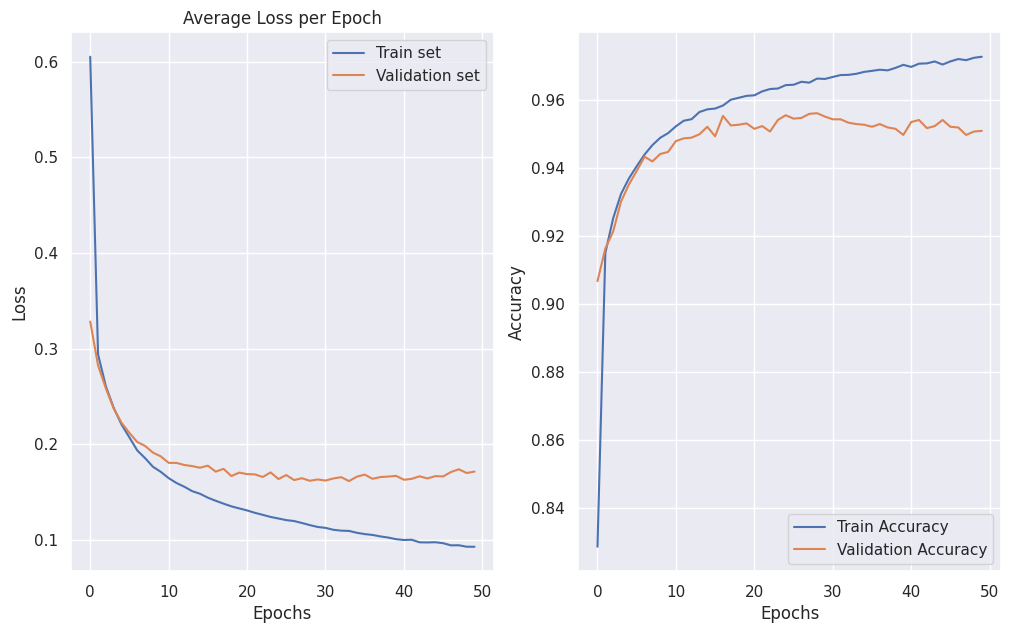

train_acc,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▃▄▆▆▆▆▇▇▇▇▇█▇█▇▇▇█████████▇█▇▇██▇▇▇▇▇▇
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
train_acc,0.9726
train_loss,0.0928
val_acc,0.9508
val_loss,0.17138


In [ ]:
wandb.init(
    project='MNIST_MLP',
    name=f'Using depth: {1}',
    config={
        "epochs": 50,
        "batch_size":256,
        "lr":1e-3,
        "input_size":28*28,
        "width":16,
        "depth":1
        })

config = wandb.config

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Currently using {device}')


# Dataloaders. (MNIST)
dl_train = FastDataloader(ds_train, config.batch_size, shuffle=True, num_workers=4)
dl_val = FastDataloader(ds_val, config.batch_size, num_workers=2)
dl_test = FastDataloader(ds_test, config.batch_size, num_workers=2)


# Instantiate model and optimizer.
model_mlp = MLP(input_size=config.input_size, width=config.width, depth=config.depth, num_classes=10).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=config.lr)

#TRAIN
train_losses, val_losses, train_accs, val_accs = training(model_mlp, dl_train, dl_val, opt, num_epochs=config.epochs, device=device)
plot_validation_curves(train_losses, val_losses, train_accs, val_accs)

wandb.finish()

>For this experiment we tested Multi Layer Perceptrons of different depths on the MNIST dataset.
The plots above (using the `plot_validation_curves` method) show the relation between validation/train losses and accs, whilst the screenshot below from wandb shows the different runs, using different depths.
As we had observed in class, increasing the depth does not really increase the accuracy of the model, both for the training and the validation set. When the model is too deep (ie d=30), the model suffers a lot and does not learn at all. Since the MNIST dataset is fairly easy, the total best depth is either 2 or 3.


>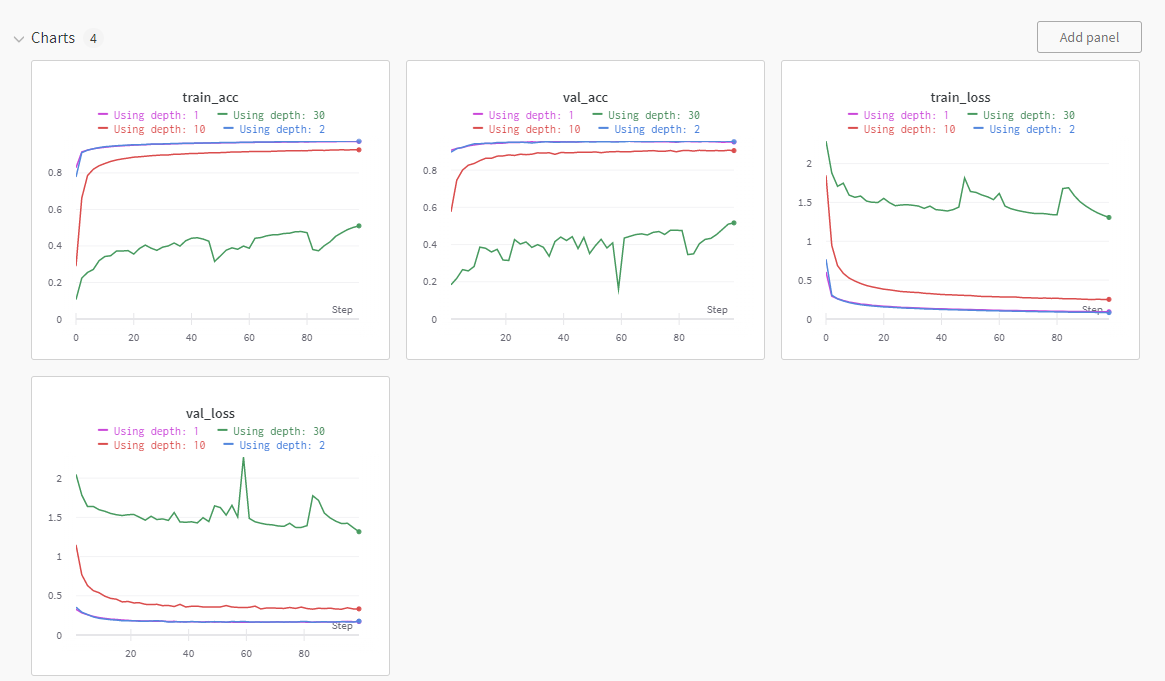

### Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 3.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

# CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, color_channels, width, depth):
        super().__init__()
        self.depth = depth
        self.input_size = input_size
        self.conv1 = nn.Conv2d(color_channels, width, (5, 5))
        self.conv2 = nn.Conv2d(width, width, (3, 3))
        self.fc1 = nn.Linear( int((((input_size - 4)/2)-(2*self.depth))**2)*width, 64)
        self.output = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)

    def forward(self, xs):
        x = self.maxpool(self.relu(self.conv1(xs)))
        for d in range(self.depth):
          x = (self.relu(self.conv2(x)))
        x = x.view(len(xs), -1)
        x = self.relu(self.fc1(x))
        x = self.output(x)
        return x

In [ ]:
#Download the CIFAR10 dataset.

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

# Validation set size.
val_size = 2000

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # mean and std for each channel in train split
])

# load train and test split
ds_train = CIFAR10(root='./data', download=True, train=True, transform=transform)
ds_test  = CIFAR10(root='./data', download=True, train=False, transform=transform)

# split training set into train and val
(ds_train, ds_val) = torch.utils.data.random_split(ds_train, (len(ds_train)-val_size, val_size))


100%|██████████| 170498071/170498071 [00:13<00:00, 12703461.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


wandb: Currently logged in as: irene-campaioli (crashkeys). Use `wandb login --relogin` to force relogin


Currently using cuda


Training epoch 0: 100%|██████████| 188/188 [00:23<00:00,  7.94it/s]


Accuracy(test): 14095/48000 / Mean Loss: 1.9032232051200055
Accuracy(val): 781/2000 / Mean Loss: 1.6634367406368256
 


Training epoch 1: 100%|██████████| 188/188 [00:13<00:00, 13.48it/s]


Accuracy(test): 20441/48000 / Mean Loss: 1.5759972302203482
Accuracy(val): 909/2000 / Mean Loss: 1.4937936514616013
 


Training epoch 2: 100%|██████████| 188/188 [00:13<00:00, 13.47it/s]


Accuracy(test): 22076/48000 / Mean Loss: 1.4768570243044103
Accuracy(val): 969/2000 / Mean Loss: 1.427187219262123
 


Training epoch 3: 100%|██████████| 188/188 [00:13<00:00, 13.46it/s]


Accuracy(test): 23093/48000 / Mean Loss: 1.4210260104625783
Accuracy(val): 972/2000 / Mean Loss: 1.4219523072242737
 


Training epoch 4: 100%|██████████| 188/188 [00:14<00:00, 13.12it/s]


Accuracy(test): 23853/48000 / Mean Loss: 1.3879807528029098
Accuracy(val): 1021/2000 / Mean Loss: 1.3674502521753311
 


Training epoch 5: 100%|██████████| 188/188 [00:13<00:00, 13.65it/s]


Accuracy(test): 24381/48000 / Mean Loss: 1.3563541541708277
Accuracy(val): 1001/2000 / Mean Loss: 1.4045848995447159
 


Training epoch 6: 100%|██████████| 188/188 [00:13<00:00, 13.84it/s]


Accuracy(test): 24918/48000 / Mean Loss: 1.3307921309420403
Accuracy(val): 1083/2000 / Mean Loss: 1.3102529346942902
 


Training epoch 7: 100%|██████████| 188/188 [00:13<00:00, 14.44it/s]


Accuracy(test): 25293/48000 / Mean Loss: 1.3048904842518745
Accuracy(val): 1060/2000 / Mean Loss: 1.3166696429252625
 


Training epoch 8: 100%|██████████| 188/188 [00:13<00:00, 14.08it/s]


Accuracy(test): 25811/48000 / Mean Loss: 1.2833781470643713
Accuracy(val): 1085/2000 / Mean Loss: 1.2886046916246414
 


Training epoch 9: 100%|██████████| 188/188 [00:14<00:00, 13.07it/s]


Accuracy(test): 26079/48000 / Mean Loss: 1.2676938810247056
Accuracy(val): 1106/2000 / Mean Loss: 1.253205195069313
 


Training epoch 10: 100%|██████████| 188/188 [00:13<00:00, 13.89it/s]


Accuracy(test): 26645/48000 / Mean Loss: 1.2444570533772732
Accuracy(val): 1111/2000 / Mean Loss: 1.2509072422981262
 


Training epoch 11: 100%|██████████| 188/188 [00:13<00:00, 13.91it/s]


Accuracy(test): 26770/48000 / Mean Loss: 1.23481840402522
Accuracy(val): 1121/2000 / Mean Loss: 1.2346107810735703
 


Training epoch 12: 100%|██████████| 188/188 [00:14<00:00, 13.40it/s]


Accuracy(test): 27169/48000 / Mean Loss: 1.212357762646168
Accuracy(val): 1138/2000 / Mean Loss: 1.2034664899110794
 


Training epoch 13: 100%|██████████| 188/188 [00:14<00:00, 13.25it/s]


Accuracy(test): 27539/48000 / Mean Loss: 1.197237898694708
Accuracy(val): 1165/2000 / Mean Loss: 1.1788110435009003
 


Training epoch 14: 100%|██████████| 188/188 [00:14<00:00, 13.24it/s]


Accuracy(test): 27789/48000 / Mean Loss: 1.1806996968832422
Accuracy(val): 1156/2000 / Mean Loss: 1.191324606537819
 


Training epoch 15: 100%|██████████| 188/188 [00:14<00:00, 13.18it/s]


Accuracy(test): 27874/48000 / Mean Loss: 1.1699758841002241
Accuracy(val): 1155/2000 / Mean Loss: 1.1966165006160736
 


Training epoch 16: 100%|██████████| 188/188 [00:14<00:00, 13.23it/s]


Accuracy(test): 28181/48000 / Mean Loss: 1.1541948153617534
Accuracy(val): 1192/2000 / Mean Loss: 1.1402688473463058
 


Training epoch 17: 100%|██████████| 188/188 [00:14<00:00, 13.29it/s]


Accuracy(test): 28527/48000 / Mean Loss: 1.1396883342494355
Accuracy(val): 1187/2000 / Mean Loss: 1.1526499837636948
 


Training epoch 18: 100%|██████████| 188/188 [00:13<00:00, 13.46it/s]


Accuracy(test): 28761/48000 / Mean Loss: 1.129174034329171
Accuracy(val): 1196/2000 / Mean Loss: 1.1315700262784958
 


Training epoch 19: 100%|██████████| 188/188 [00:14<00:00, 13.41it/s]


Accuracy(test): 28871/48000 / Mean Loss: 1.1185124059940905
Accuracy(val): 1189/2000 / Mean Loss: 1.1439149677753448
 


Training epoch 20: 100%|██████████| 188/188 [00:14<00:00, 13.19it/s]


Accuracy(test): 28766/48000 / Mean Loss: 1.1182087853233864
Accuracy(val): 1209/2000 / Mean Loss: 1.1336768120527267
 


Training epoch 21: 100%|██████████| 188/188 [00:14<00:00, 13.33it/s]


Accuracy(test): 29230/48000 / Mean Loss: 1.1060712375539414
Accuracy(val): 1188/2000 / Mean Loss: 1.132949285209179
 


Training epoch 22: 100%|██████████| 188/188 [00:14<00:00, 13.42it/s]


Accuracy(test): 29326/48000 / Mean Loss: 1.095883106297635
Accuracy(val): 1208/2000 / Mean Loss: 1.1246957704424858
 


Training epoch 23: 100%|██████████| 188/188 [00:14<00:00, 13.38it/s]


Accuracy(test): 29531/48000 / Mean Loss: 1.0879062490260347
Accuracy(val): 1211/2000 / Mean Loss: 1.1146980300545692
 


Training epoch 24: 100%|██████████| 188/188 [00:13<00:00, 13.43it/s]


Accuracy(test): 29572/48000 / Mean Loss: 1.0819391868215926
Accuracy(val): 1189/2000 / Mean Loss: 1.1025498360395432
 


Training epoch 25: 100%|██████████| 188/188 [00:13<00:00, 13.51it/s]


Accuracy(test): 29815/48000 / Mean Loss: 1.0720104765384755
Accuracy(val): 1216/2000 / Mean Loss: 1.1121246442198753
 


Training epoch 26: 100%|██████████| 188/188 [00:14<00:00, 13.40it/s]


Accuracy(test): 29758/48000 / Mean Loss: 1.0683472048729024
Accuracy(val): 1206/2000 / Mean Loss: 1.1253623515367508
 


Training epoch 27: 100%|██████████| 188/188 [00:13<00:00, 13.71it/s]


Accuracy(test): 29923/48000 / Mean Loss: 1.0617614753068763
Accuracy(val): 1214/2000 / Mean Loss: 1.1036975979804993
 


Training epoch 28: 100%|██████████| 188/188 [00:13<00:00, 14.10it/s]


Accuracy(test): 30061/48000 / Mean Loss: 1.0590717976397657
Accuracy(val): 1196/2000 / Mean Loss: 1.1270939260721207
 


Training epoch 29: 100%|██████████| 188/188 [00:13<00:00, 14.05it/s]


Accuracy(test): 30043/48000 / Mean Loss: 1.0544992479238104
Accuracy(val): 1198/2000 / Mean Loss: 1.1023242622613907
 


Training epoch 30: 100%|██████████| 188/188 [00:13<00:00, 14.08it/s]


Accuracy(test): 30152/48000 / Mean Loss: 1.0491435635597148
Accuracy(val): 1211/2000 / Mean Loss: 1.0980530455708504
 


Training epoch 31: 100%|██████████| 188/188 [00:13<00:00, 14.24it/s]


Accuracy(test): 30314/48000 / Mean Loss: 1.041921540143642
Accuracy(val): 1211/2000 / Mean Loss: 1.1113004386425018
 


Training epoch 32: 100%|██████████| 188/188 [00:13<00:00, 14.05it/s]


Accuracy(test): 30442/48000 / Mean Loss: 1.0315634094654245
Accuracy(val): 1225/2000 / Mean Loss: 1.1007860153913498
 


Training epoch 33: 100%|██████████| 188/188 [00:13<00:00, 14.06it/s]


Accuracy(test): 30544/48000 / Mean Loss: 1.0317275505116645
Accuracy(val): 1220/2000 / Mean Loss: 1.1000114753842354
 


Training epoch 34: 100%|██████████| 188/188 [00:13<00:00, 13.55it/s]


Accuracy(test): 30624/48000 / Mean Loss: 1.027485712728602
Accuracy(val): 1256/2000 / Mean Loss: 1.0698104724287987
 


Training epoch 35: 100%|██████████| 188/188 [00:13<00:00, 13.54it/s]


Accuracy(test): 30754/48000 / Mean Loss: 1.019179454826294
Accuracy(val): 1234/2000 / Mean Loss: 1.0898174718022346
 


Training epoch 36: 100%|██████████| 188/188 [00:13<00:00, 13.46it/s]


Accuracy(test): 30807/48000 / Mean Loss: 1.0154410042661302
Accuracy(val): 1206/2000 / Mean Loss: 1.1110346764326096
 


Training epoch 37: 100%|██████████| 188/188 [00:13<00:00, 13.59it/s]


Accuracy(test): 30830/48000 / Mean Loss: 1.0113019315486258
Accuracy(val): 1241/2000 / Mean Loss: 1.0937854498624802
 


Training epoch 38: 100%|██████████| 188/188 [00:13<00:00, 13.64it/s]


Accuracy(test): 30878/48000 / Mean Loss: 1.0102617569426273
Accuracy(val): 1230/2000 / Mean Loss: 1.1012072041630745
 


Training epoch 39: 100%|██████████| 188/188 [00:13<00:00, 13.53it/s]


Accuracy(test): 30944/48000 / Mean Loss: 1.002634012318672
Accuracy(val): 1222/2000 / Mean Loss: 1.0973945036530495
 


Training epoch 40: 100%|██████████| 188/188 [00:13<00:00, 13.58it/s]


Accuracy(test): 31132/48000 / Mean Loss: 0.997915414736626
Accuracy(val): 1243/2000 / Mean Loss: 1.0825902074575424
 


Training epoch 41: 100%|██████████| 188/188 [00:14<00:00, 13.16it/s]


Accuracy(test): 31089/48000 / Mean Loss: 0.9976203961575285
Accuracy(val): 1247/2000 / Mean Loss: 1.080964669585228
 


Training epoch 42: 100%|██████████| 188/188 [00:13<00:00, 13.52it/s]


Accuracy(test): 31088/48000 / Mean Loss: 0.9954170638576467
Accuracy(val): 1261/2000 / Mean Loss: 1.0748843625187874
 


Training epoch 43: 100%|██████████| 188/188 [00:13<00:00, 13.52it/s]


Accuracy(test): 31196/48000 / Mean Loss: 0.9889668448174254
Accuracy(val): 1235/2000 / Mean Loss: 1.0857559591531754
 


Training epoch 44: 100%|██████████| 188/188 [00:13<00:00, 13.52it/s]


Accuracy(test): 31263/48000 / Mean Loss: 0.9846975169283279
Accuracy(val): 1253/2000 / Mean Loss: 1.0817235931754112
 


Training epoch 45: 100%|██████████| 188/188 [00:13<00:00, 13.63it/s]


Accuracy(test): 31273/48000 / Mean Loss: 0.9812225677231525
Accuracy(val): 1248/2000 / Mean Loss: 1.079239934682846
 


Training epoch 46: 100%|██████████| 188/188 [00:14<00:00, 13.40it/s]


Accuracy(test): 31350/48000 / Mean Loss: 0.9811904386002966
Accuracy(val): 1272/2000 / Mean Loss: 1.0870001688599586
 


Training epoch 47: 100%|██████████| 188/188 [00:14<00:00, 13.28it/s]


Accuracy(test): 31331/48000 / Mean Loss: 0.9800663929670415
Accuracy(val): 1243/2000 / Mean Loss: 1.0813139528036118
 


Training epoch 48: 100%|██████████| 188/188 [00:14<00:00, 13.40it/s]


Accuracy(test): 31443/48000 / Mean Loss: 0.9756605187629132
Accuracy(val): 1261/2000 / Mean Loss: 1.0741620361804962
 


Training epoch 49: 100%|██████████| 188/188 [00:13<00:00, 14.03it/s]


Accuracy(test): 31590/48000 / Mean Loss: 0.969911720207397
Accuracy(val): 1272/2000 / Mean Loss: 1.0660905465483665
 


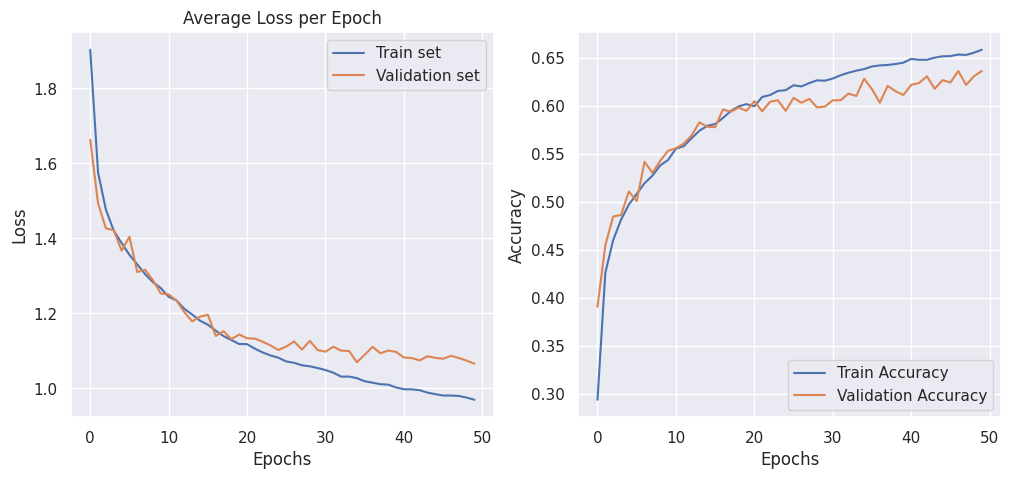

train_acc,▁▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
train_loss,█▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███▇████
val_loss,█▆▅▅▅▄▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
train_acc,0.65812
train_loss,0.96991
val_acc,0.636
val_loss,1.06609


In [ ]:
wandb.init(
    project='PlainCNN',
    name=f'Using depth: {3}',
    config={
        "epochs": 50,
        "batch_size":256,
        "lr":1e-3,
        "input_size":32,
        "width":10,
        "depth":3
        })

config = wandb.config

# Training hyperparameters.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Currently using {device}')


dl_train = FastDataloader(ds_train, config.batch_size, shuffle=True, num_workers=4)
dl_val = FastDataloader(ds_val, config.batch_size, num_workers=2)
dl_test = FastDataloader(ds_test, config.batch_size, num_workers=2)


# Instantiate model and optimizer.
cnn = CNN(input_size=config.input_size, color_channels=3, width=config.width, depth=config.depth).to(device)
opt = torch.optim.Adam(params=cnn.parameters(), lr=config.lr)

#TRAIN
train_losses, val_losses, train_accs, val_accs = training(cnn, dl_train, dl_val, opt, num_epochs=config.epochs, device=device)
plot_validation_curves(train_losses, val_losses, train_accs, val_accs)

wandb.finish()

>Since the convolutions and the MaxPool layers reduce the initial size of the image, the maximum depth that we can test for this model is d=6.
As expected, increasing the depth does not make the model perfom better. The deepest model in fact has the worst performance overall. The best case is probably d=3, since it has the lowest validation loss.

>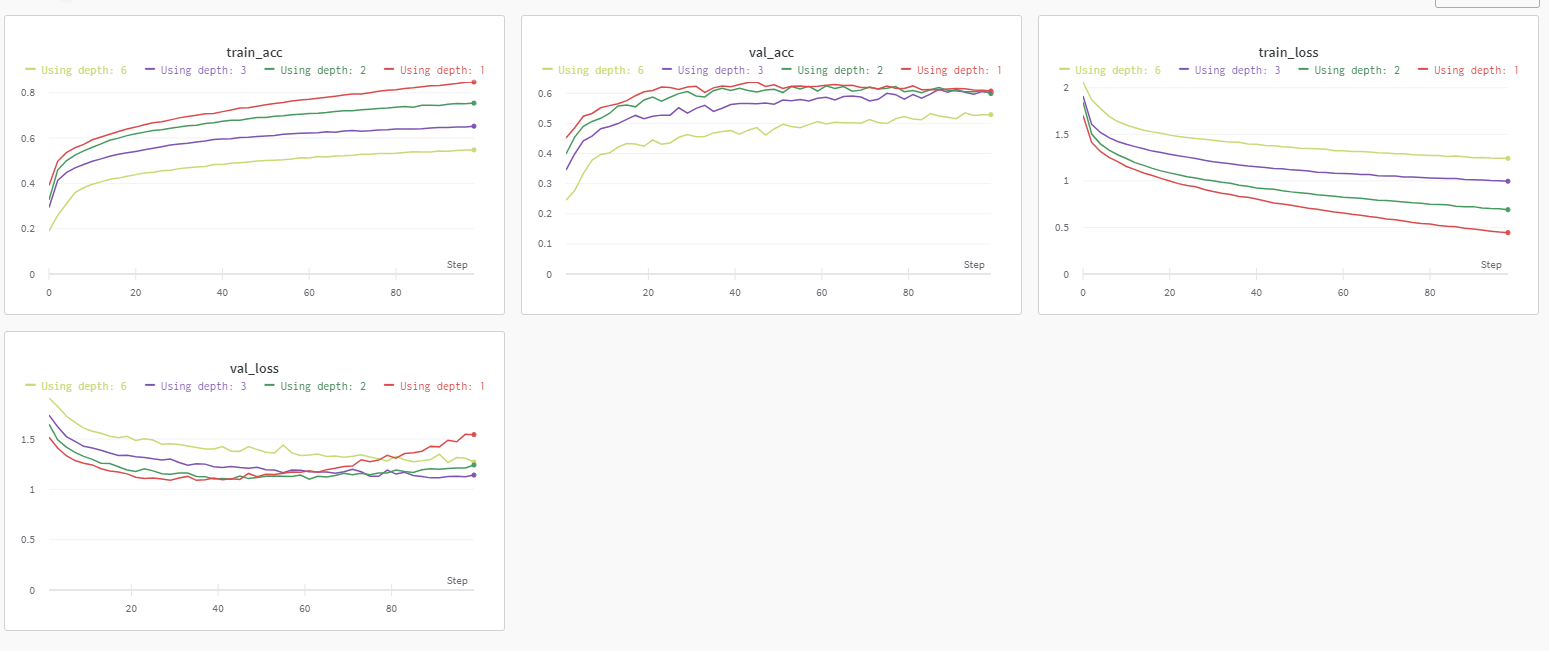

In [ ]:
#We save the model with d=3 for later

torch.save(cnn, '/content/data/cnn.pth')

# ResNet

In [ ]:
class ResCNN(nn.Module):
    def __init__(self, input_size, width, depth):
        super().__init__()
        self.width = width
        self.depth = depth
        self.input_size = input_size
        self.conv1 = nn.Conv2d(3, self.width, (5, 5))
        self.conv2 = nn.Conv2d(self.width, self.width, (3, 3), padding='same')  #zero padding
        self.fc1 = nn.Linear(self.width*49, 64)
        self.output = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)


    def convblock(self, x):
      x = self.relu(self.conv2(x))
      x = self.relu(self.conv2(x))
      return x

    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        for d in range(self.depth):
          xs = x
          x = self.convblock(x)
          x = xs + x
        x = self.maxpool(x)
        x = x.view(len(xs), -1)
        x = self.relu(self.fc1(x))
        x = self.output(x)
        return x


wandb: Currently logged in as: irene-campaioli (crashkeys). Use `wandb login --relogin` to force relogin


Currently using cuda


Training epoch 0: 100%|██████████| 188/188 [00:22<00:00,  8.41it/s]


Accuracy(test): 20938/48000 / Mean Loss: 1.573863553239944
Accuracy(val): 1052/2000 / Mean Loss: 1.3266351521015167
 


Training epoch 1: 100%|██████████| 188/188 [00:14<00:00, 12.68it/s]


Accuracy(test): 27127/48000 / Mean Loss: 1.2157777275176758
Accuracy(val): 1121/2000 / Mean Loss: 1.2386179268360138
 


Training epoch 2: 100%|██████████| 188/188 [00:14<00:00, 12.86it/s]


Accuracy(test): 29696/48000 / Mean Loss: 1.0827120412537392
Accuracy(val): 1202/2000 / Mean Loss: 1.1074935793876648
 


Training epoch 3: 100%|██████████| 188/188 [00:15<00:00, 11.95it/s]


Accuracy(test): 31251/48000 / Mean Loss: 0.9875979020874551
Accuracy(val): 1281/2000 / Mean Loss: 1.0248465463519096
 


Training epoch 4: 100%|██████████| 188/188 [00:14<00:00, 12.57it/s]


Accuracy(test): 32358/48000 / Mean Loss: 0.9286100772467065
Accuracy(val): 1328/2000 / Mean Loss: 0.9938700050115585
 


Training epoch 5: 100%|██████████| 188/188 [00:14<00:00, 12.93it/s]


Accuracy(test): 33307/48000 / Mean Loss: 0.8740003089955513
Accuracy(val): 1333/2000 / Mean Loss: 1.0109114199876785
 


Training epoch 6: 100%|██████████| 188/188 [00:14<00:00, 12.91it/s]


Accuracy(test): 33989/48000 / Mean Loss: 0.8343678354582889
Accuracy(val): 1365/2000 / Mean Loss: 0.9355184584856033
 


Training epoch 7: 100%|██████████| 188/188 [00:14<00:00, 12.82it/s]


Accuracy(test): 34726/48000 / Mean Loss: 0.792642741444263
Accuracy(val): 1368/2000 / Mean Loss: 0.9353370517492294
 


Training epoch 8: 100%|██████████| 188/188 [00:14<00:00, 12.89it/s]


Accuracy(test): 35186/48000 / Mean Loss: 0.7610253403161434
Accuracy(val): 1380/2000 / Mean Loss: 0.9001733213663101
 


Training epoch 9: 100%|██████████| 188/188 [00:14<00:00, 13.00it/s]


Accuracy(test): 35661/48000 / Mean Loss: 0.7325699570331168
Accuracy(val): 1378/2000 / Mean Loss: 0.9169435650110245
 


Training epoch 10: 100%|██████████| 188/188 [00:14<00:00, 12.94it/s]


Accuracy(test): 36209/48000 / Mean Loss: 0.6990389963413807
Accuracy(val): 1398/2000 / Mean Loss: 0.8799448609352112
 


Training epoch 11: 100%|██████████| 188/188 [00:14<00:00, 12.91it/s]


Accuracy(test): 36687/48000 / Mean Loss: 0.6703550712542331
Accuracy(val): 1423/2000 / Mean Loss: 0.8816873282194138
 


Training epoch 12: 100%|██████████| 188/188 [00:14<00:00, 12.72it/s]


Accuracy(test): 36937/48000 / Mean Loss: 0.6555743055774811
Accuracy(val): 1424/2000 / Mean Loss: 0.8832736238837242
 


Training epoch 13: 100%|██████████| 188/188 [00:14<00:00, 12.95it/s]


Accuracy(test): 37362/48000 / Mean Loss: 0.631779432772322
Accuracy(val): 1399/2000 / Mean Loss: 0.9047059714794159
 


Training epoch 14: 100%|██████████| 188/188 [00:14<00:00, 12.81it/s]


Accuracy(test): 37673/48000 / Mean Loss: 0.6100318335155224
Accuracy(val): 1389/2000 / Mean Loss: 0.956866092979908
 


Training epoch 15: 100%|██████████| 188/188 [00:14<00:00, 12.90it/s]


Accuracy(test): 38111/48000 / Mean Loss: 0.5848427632070602
Accuracy(val): 1389/2000 / Mean Loss: 0.9397497549653053
 


Training epoch 16: 100%|██████████| 188/188 [00:14<00:00, 13.01it/s]


Accuracy(test): 38363/48000 / Mean Loss: 0.5685020474360344
Accuracy(val): 1432/2000 / Mean Loss: 0.9061747714877129
 


Training epoch 17: 100%|██████████| 188/188 [00:14<00:00, 12.87it/s]


Accuracy(test): 38748/48000 / Mean Loss: 0.5441294315647571
Accuracy(val): 1407/2000 / Mean Loss: 0.9491204768419266
 


Training epoch 18: 100%|██████████| 188/188 [00:16<00:00, 11.71it/s]


Accuracy(test): 38941/48000 / Mean Loss: 0.529635341560587
Accuracy(val): 1400/2000 / Mean Loss: 0.9699034467339516
 


Training epoch 19: 100%|██████████| 188/188 [00:14<00:00, 12.76it/s]


Accuracy(test): 39246/48000 / Mean Loss: 0.514062705667729
Accuracy(val): 1413/2000 / Mean Loss: 0.9739020317792892
 


Training epoch 20: 100%|██████████| 188/188 [00:14<00:00, 12.80it/s]


Accuracy(test): 39690/48000 / Mean Loss: 0.49059133516981246
Accuracy(val): 1401/2000 / Mean Loss: 0.9887177348136902
 


Training epoch 21: 100%|██████████| 188/188 [00:14<00:00, 12.77it/s]


Accuracy(test): 39902/48000 / Mean Loss: 0.4719552686239811
Accuracy(val): 1413/2000 / Mean Loss: 1.0219934731721878
 


Training epoch 22: 100%|██████████| 188/188 [00:14<00:00, 12.82it/s]


Accuracy(test): 40166/48000 / Mean Loss: 0.45688435134101424
Accuracy(val): 1412/2000 / Mean Loss: 0.9922462031245232
 


Training epoch 23: 100%|██████████| 188/188 [00:14<00:00, 12.61it/s]


Accuracy(test): 40399/48000 / Mean Loss: 0.4440340505952531
Accuracy(val): 1395/2000 / Mean Loss: 1.0556024387478828
 


Training epoch 24: 100%|██████████| 188/188 [00:14<00:00, 12.78it/s]


Accuracy(test): 40669/48000 / Mean Loss: 0.4322335387163974
Accuracy(val): 1380/2000 / Mean Loss: 1.0649827495217323
 


Training epoch 25: 100%|██████████| 188/188 [00:14<00:00, 12.93it/s]


Accuracy(test): 40905/48000 / Mean Loss: 0.414295106333621
Accuracy(val): 1391/2000 / Mean Loss: 1.1534263715147972
 


Training epoch 26: 100%|██████████| 188/188 [00:14<00:00, 12.99it/s]


Accuracy(test): 41002/48000 / Mean Loss: 0.4081079833050992
Accuracy(val): 1416/2000 / Mean Loss: 1.1469798758625984
 


Training epoch 27: 100%|██████████| 188/188 [00:14<00:00, 12.80it/s]


Accuracy(test): 41439/48000 / Mean Loss: 0.3855066014097092
Accuracy(val): 1396/2000 / Mean Loss: 1.1405405029654503
 


Training epoch 28: 100%|██████████| 188/188 [00:14<00:00, 12.85it/s]


Accuracy(test): 41469/48000 / Mean Loss: 0.38237492977938753
Accuracy(val): 1384/2000 / Mean Loss: 1.1577824875712395
 


Training epoch 29: 100%|██████████| 188/188 [00:14<00:00, 12.73it/s]


Accuracy(test): 41939/48000 / Mean Loss: 0.3523446120163228
Accuracy(val): 1379/2000 / Mean Loss: 1.1963673532009125
 


Training epoch 30: 100%|██████████| 188/188 [00:14<00:00, 12.89it/s]


Accuracy(test): 42204/48000 / Mean Loss: 0.342671015953764
Accuracy(val): 1377/2000 / Mean Loss: 1.2189846858382225
 


Training epoch 31: 100%|██████████| 188/188 [00:14<00:00, 12.82it/s]


Accuracy(test): 42485/48000 / Mean Loss: 0.32038044208224786
Accuracy(val): 1413/2000 / Mean Loss: 1.290575698018074
 


Training epoch 32: 100%|██████████| 188/188 [00:14<00:00, 12.96it/s]


Accuracy(test): 42466/48000 / Mean Loss: 0.32299746866238876
Accuracy(val): 1388/2000 / Mean Loss: 1.243260532617569
 


Training epoch 33: 100%|██████████| 188/188 [00:14<00:00, 12.83it/s]


Accuracy(test): 42740/48000 / Mean Loss: 0.3044438992250473
Accuracy(val): 1385/2000 / Mean Loss: 1.3478444069623947
 


Training epoch 34: 100%|██████████| 188/188 [00:14<00:00, 12.80it/s]


Accuracy(test): 42538/48000 / Mean Loss: 0.3115155982210281
Accuracy(val): 1400/2000 / Mean Loss: 1.3334191590547562
 


Training epoch 35: 100%|██████████| 188/188 [00:14<00:00, 12.67it/s]


Accuracy(test): 42995/48000 / Mean Loss: 0.285398791999893
Accuracy(val): 1374/2000 / Mean Loss: 1.3755556046962738
 


Training epoch 36: 100%|██████████| 188/188 [00:14<00:00, 12.88it/s]


Accuracy(test): 43004/48000 / Mean Loss: 0.2848459731866705
Accuracy(val): 1370/2000 / Mean Loss: 1.3900957703590393
 


Training epoch 37: 100%|██████████| 188/188 [00:14<00:00, 12.94it/s]


Accuracy(test): 43515/48000 / Mean Loss: 0.2583627563683277
Accuracy(val): 1386/2000 / Mean Loss: 1.4428313225507736
 


Training epoch 38: 100%|██████████| 188/188 [00:15<00:00, 12.29it/s]


Accuracy(test): 43516/48000 / Mean Loss: 0.2570421464265661
Accuracy(val): 1346/2000 / Mean Loss: 1.4312350153923035
 


Training epoch 39: 100%|██████████| 188/188 [00:14<00:00, 12.68it/s]


Accuracy(test): 43709/48000 / Mean Loss: 0.24670873289095593
Accuracy(val): 1377/2000 / Mean Loss: 1.561164230108261
 


Training epoch 40: 100%|██████████| 188/188 [00:14<00:00, 12.72it/s]


Accuracy(test): 44014/48000 / Mean Loss: 0.22934074256014317
Accuracy(val): 1384/2000 / Mean Loss: 1.5887310653924942
 


Training epoch 41: 100%|██████████| 188/188 [00:14<00:00, 12.70it/s]


Accuracy(test): 43945/48000 / Mean Loss: 0.230631596864538
Accuracy(val): 1374/2000 / Mean Loss: 1.5942765176296234
 


Training epoch 42: 100%|██████████| 188/188 [00:14<00:00, 12.88it/s]


Accuracy(test): 44256/48000 / Mean Loss: 0.21609399832309562
Accuracy(val): 1369/2000 / Mean Loss: 1.6679493188858032
 


Training epoch 43: 100%|██████████| 188/188 [00:14<00:00, 12.87it/s]


Accuracy(test): 44466/48000 / Mean Loss: 0.2056458778679371
Accuracy(val): 1367/2000 / Mean Loss: 1.6376128047704697
 


Training epoch 44: 100%|██████████| 188/188 [00:14<00:00, 13.08it/s]


Accuracy(test): 44437/48000 / Mean Loss: 0.2041998000300311
Accuracy(val): 1383/2000 / Mean Loss: 1.7081882059574127
 


Training epoch 45: 100%|██████████| 188/188 [00:14<00:00, 13.09it/s]


Accuracy(test): 44468/48000 / Mean Loss: 0.19983446154188603
Accuracy(val): 1354/2000 / Mean Loss: 1.8418196141719818
 


Training epoch 46: 100%|██████████| 188/188 [00:14<00:00, 12.93it/s]


Accuracy(test): 44652/48000 / Mean Loss: 0.1916039626094255
Accuracy(val): 1361/2000 / Mean Loss: 1.7708558291196823
 


Training epoch 47: 100%|██████████| 188/188 [00:14<00:00, 13.15it/s]


Accuracy(test): 44751/48000 / Mean Loss: 0.18666068020653218
Accuracy(val): 1340/2000 / Mean Loss: 1.8266116678714752
 


Training epoch 48: 100%|██████████| 188/188 [00:14<00:00, 13.23it/s]


Accuracy(test): 44690/48000 / Mean Loss: 0.18641638621053797
Accuracy(val): 1360/2000 / Mean Loss: 1.8691920787096024
 


Training epoch 49: 100%|██████████| 188/188 [00:14<00:00, 13.10it/s]


Accuracy(test): 44730/48000 / Mean Loss: 0.18603602269704037
Accuracy(val): 1357/2000 / Mean Loss: 1.9051360934972763
 


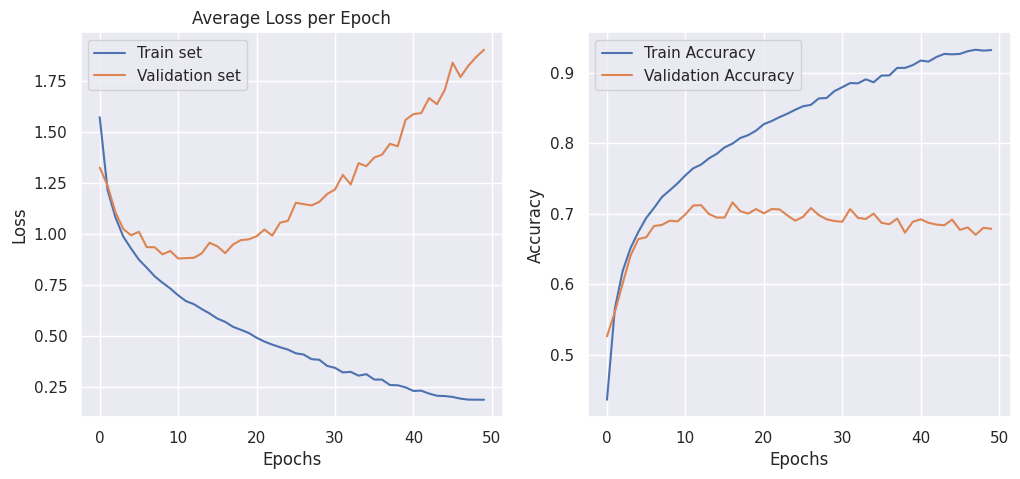

train_acc,▁▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▆▆▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▄▅▆▇▇▇▇██▇▇██▇▇██▇▇█▇▇▇█▇▇▇▇▇▆▇▇▇▇▇▇▆▇
val_loss,▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▃▄▄▄▅▅▆▆▆▆█▇▇█
train_acc,0.93188
train_loss,0.18604
val_acc,0.6785
val_loss,1.90514


In [ ]:
wandb.init(
    settings=wandb.Settings(start_method="fork"),
    project='Resnet',
    name=f'Using depth: {6}',
    config={
        "epochs": 50,
        "batch_size":256,
        "lr":1e-3,
        "input_size":32,
        "width":32,
        "depth":6
        })

config = wandb.config

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Currently using {device}')


dl_train = FastDataloader(ds_train, config.batch_size, shuffle=True, num_workers=4)
dl_val = FastDataloader(ds_val, config.batch_size, num_workers=2)
dl_test = FastDataloader(ds_test, config.batch_size, num_workers=2)


# Instantiate model and optimizer.
rescnn = ResCNN(input_size=config.input_size, width=config.width, depth=config.depth).to(device)
opt = torch.optim.Adam(params=rescnn.parameters(), lr=config.lr)

#TRAIN
train_losses, val_losses, train_accs, val_accs = training(rescnn, dl_train, dl_val, opt, num_epochs=config.epochs, device=device)
plot_validation_curves(train_losses, val_losses, train_accs, val_accs)

wandb.finish()

>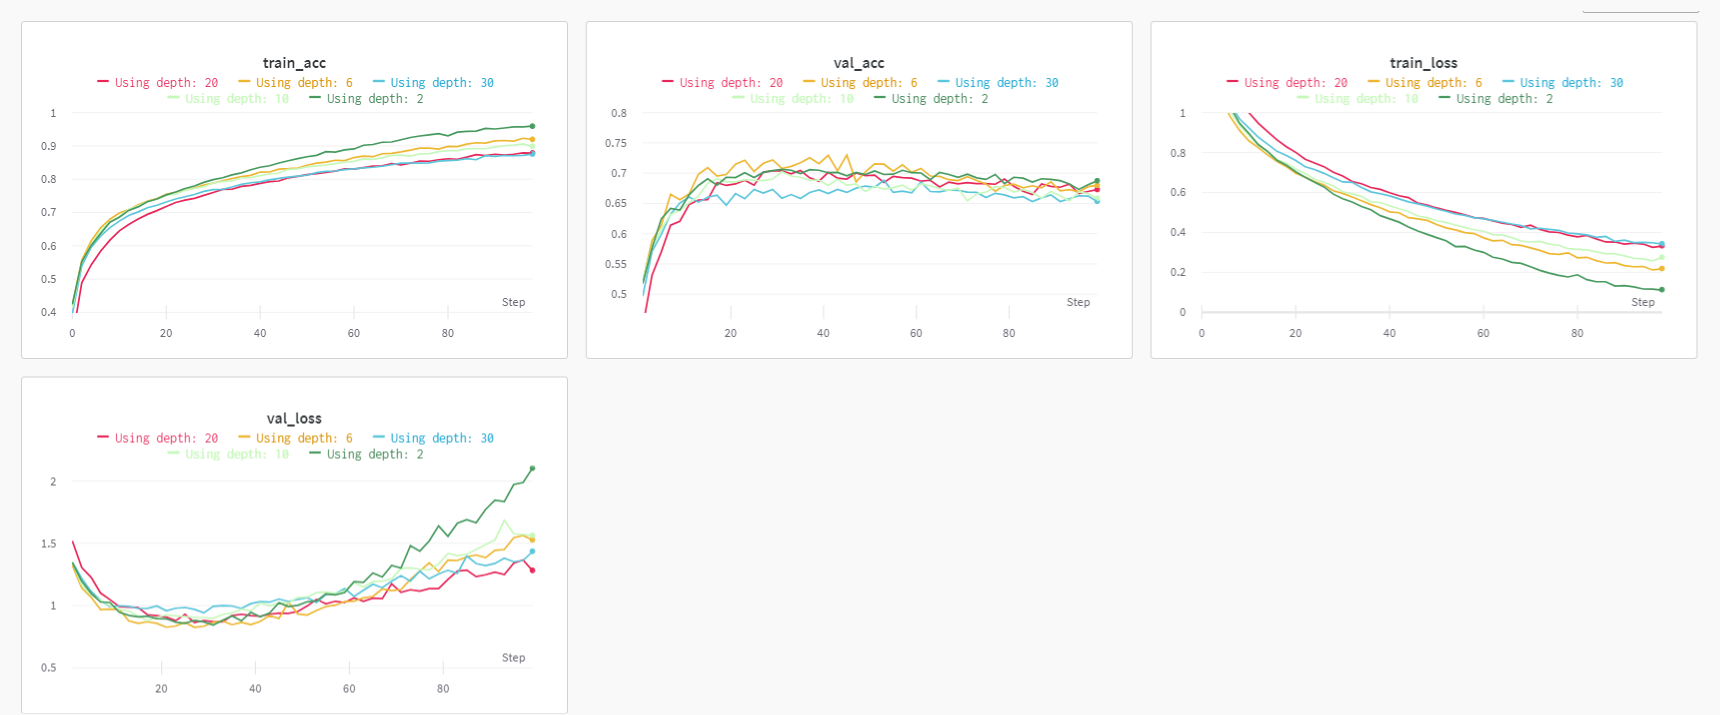

>In this model we can see a much more pronounced overfitting, compared to the MLP and plain CNN and it's maybe a bit more difficult to see the results discussed in class. It seems like deepening the ResNet too much is not always the best result.
But it is true that a deeper ResNet has better accuracy than a plain CNN. From this project and the plain CNN one on WandB we can see that the validation accuracy/loss is:

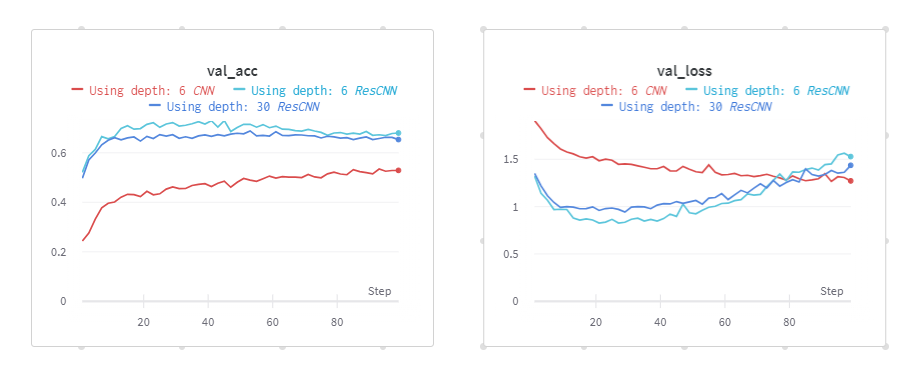


So, as expected, a deep Residual Network has a better accuracy than a plain CNN of the same depth.


-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.2: Fully-convolutionalize a network.
Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

>We now create a fully convolutional model based on the CNN defined before. To see the differences, we take the cnn of depth 3 saved before and print the summary.

In [ ]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cnn_d3 = torch.load('/content/data/cnnd3.pth')

summary(cnn_d3, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             760
              ReLU-2           [-1, 10, 28, 28]               0
         MaxPool2d-3           [-1, 10, 14, 14]               0
            Conv2d-4           [-1, 10, 12, 12]             910
              ReLU-5           [-1, 10, 12, 12]               0
            Conv2d-6           [-1, 10, 10, 10]             910
              ReLU-7           [-1, 10, 10, 10]               0
            Conv2d-8             [-1, 10, 8, 8]             910
              ReLU-9             [-1, 10, 8, 8]               0
           Linear-10                   [-1, 64]          41,024
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 10]             650
Total params: 45,164
Trainable params: 45,164
Non-trainable params: 0
---------------------------------

In [7]:
class FC_CNN(nn.Module):
    def __init__(self, input_size, color_channels, width, depth):
        super().__init__()
        self.depth = depth
        self.input_size = input_size
        self.conv1 = nn.Conv2d(color_channels, width, (5, 5), padding='same')
        self.conv2 = nn.Conv2d(width, width, (3, 3), padding='same')
        self.convfc1 = nn.Conv2d(in_channels=width, out_channels=width, kernel_size=(1,1))
        self.output = nn.Conv2d(in_channels=width, out_channels=10, kernel_size=(1,1)) #10=num_classes
        self.relu = nn.ReLU()

    def forward(self, xs):
        x = self.relu(self.conv1(xs))
        for d in range(self.depth):
          x = (self.relu(self.conv2(x)))
        x = self.relu(self.convfc1(x))
        x = self.output(x)
        return x


In [9]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size=28
width=32
depth=3


cnn_fc = FC_CNN(input_size, color_channels=1, width=width, depth=depth)
cnn_fc.to(device)
summary(cnn_fc, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           9,248
              ReLU-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 32, 28, 28]           9,248
              ReLU-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 32, 28, 28]           9,248
              ReLU-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 32, 28, 28]           1,056
             ReLU-10           [-1, 32, 28, 28]               0
           Conv2d-11           [-1, 10, 28, 28]             330
Total params: 29,962
Trainable params: 29,962
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

> Note how in the standard version with fully-connected layers the output's shape is `[-1, 10]` while in the fully-convolutional one is `[-1, 10, 28, 28]` since we have a classification for each pixel.

> Now we train the model and test it as a digit detector.

In [10]:
import torch
import numpy as np
from torch.utils.data import Dataset

class TargetTransform:
    def __init__(self, width, height):
        self.w = width
        self.h = height

    def __call__(self, y):
        return torch.from_numpy(np.full((self.w, self.h), y, dtype=np.int64))

class DatasetWrapper(Dataset):
    def __init__(self, dataset, size, n_cols, n_rows):
        self.dataset = dataset
        n = len(dataset)
        rng = np.random.default_rng()
        self.indexes = rng.choice(n, (size, n_cols, n_rows))

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        image_indexes = self.indexes[idx]
        x_sample = list()
        y_sample = list()
        for row in image_indexes:
            x_row = list()
            y_row = list()
            for col in row:
                x, y = self.dataset[col]
                x_row.append(x)
                y_row.append(y)
            x_sample.append(torch.cat(x_row, dim=1))
            y_sample.append(torch.cat(y_row, dim=0))
        return torch.cat(x_sample, dim=2), torch.cat(y_sample, dim=1)

In [11]:
#MNIST
input_size=28
color_channels=1
width=32
depth=3

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform, target_transform=TargetTransform(28,28))
ds_test = MNIST(root='./data', train=False, download=True, transform=transform, target_transform=TargetTransform(28,28))

# Split train into train and validation.
val_size = 5000
(ds_train, ds_val) = torch.utils.data.random_split(ds_train, (len(ds_train)-val_size, val_size))


dl_train = FastDataloader(ds_train, 128, shuffle=True, num_workers=4)
dl_val = FastDataloader(ds_val, 128, num_workers=2)
dl_test = FastDataloader(ds_test, 128, num_workers=2)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
def visualize_img(imgs):
    imgs = (imgs * 0.3081)+0.1307   # unnormalize to see original colors
    fig = plt.figure(figsize=(15, 4), dpi=80)

    for i, img in enumerate(imgs):
        ax = fig.add_subplot(4,10, i+1)
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()


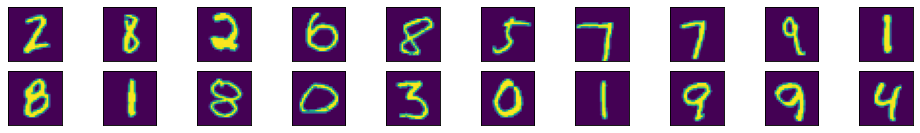

In [17]:
img_v, lab_v = next(iter(dl_test))
visualize_img(img_v[:20])

In [18]:
ds_test1 = DatasetWrapper(ds_test, size=1000, n_rows=2, n_cols=3)
ds_test2 = DatasetWrapper(ds_test, size=2000, n_rows=4, n_cols=2)

dl_test1 = torch.utils.data.DataLoader(ds_test1, 128, num_workers=4)
dl_test2 = torch.utils.data.DataLoader(ds_test2, 128, num_workers=4)

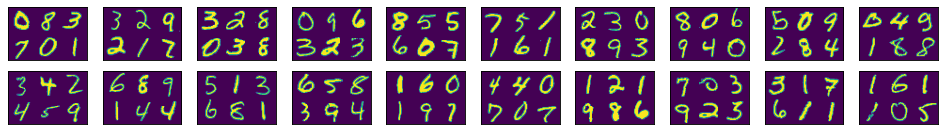

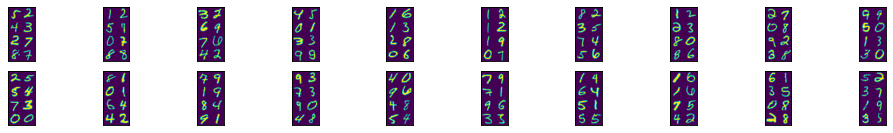

In [19]:
img_v, lab_v = next(iter(dl_test1))
img_v2, lav_v2 = next(iter(dl_test2))
visualize_img(img_v[:20])
visualize_img(img_v2[:20])

In [20]:
cnn_fc = FC_CNN(input_size=28, color_channels=1, width=width, depth=depth).to(device)
opt = torch.optim.Adam(params=cnn_fc.parameters(), lr=1e-3)

In [27]:
wandb.init(
    settings=wandb.Settings(start_method="fork"),
    project='FC_CNN',
    name=f'fc_cnn',
    config={
        "epochs": 50,
        "batch_size":1,
        "lr":1e-3,
        "input_size":28,
        "width":10,
        "depth":3
        })

config = wandb.config

#TRAIN
train_losses, val_losses, train_accs, val_accs = training(cnn_fc, dl_train, dl_val, opt, num_epochs=15, device=device)


wandb.finish()

wandb: Currently logged in as: irene-campaioli (crashkeys). Use `wandb login --relogin` to force relogin


Training epoch 0: 100%|██████████| 430/430 [00:19<00:00, 21.67it/s]


Accuracy(test): 52559/55000
Mean Loss: 0.4864898058134465
Accuracy(val): 5000/5000 / Mean Loss: 1.5913254543420407e-06
Mean Loss: 1.5913254543420407e-06


Training epoch 1: 100%|██████████| 430/430 [00:19<00:00, 21.91it/s]


Accuracy(test): 55000/55000
Mean Loss: 1.0467383346653954e-06
Accuracy(val): 5000/5000 / Mean Loss: 7.421006799290808e-07
Mean Loss: 7.421006799290808e-07


Training epoch 2: 100%|██████████| 430/430 [00:19<00:00, 22.12it/s]


Accuracy(test): 55000/55000
Mean Loss: 5.513805118283038e-07
Accuracy(val): 5000/5000 / Mean Loss: 3.7157427357215056e-07
Mean Loss: 3.7157427357215056e-07


Training epoch 3: 100%|██████████| 430/430 [00:18<00:00, 22.66it/s]


Accuracy(test): 55000/55000
Mean Loss: 3.218010603663864e-07
Accuracy(val): 5000/5000 / Mean Loss: 2.477550058443967e-07
Mean Loss: 2.477550058443967e-07


Training epoch 4: 100%|██████████| 430/430 [00:18<00:00, 22.85it/s]


Accuracy(test): 55000/55000
Mean Loss: 2.1490650078108894e-07
Accuracy(val): 5000/5000 / Mean Loss: 1.2754458467156837e-07
Mean Loss: 1.2754458467156837e-07


Training epoch 5: 100%|██████████| 430/430 [00:19<00:00, 21.80it/s]


Accuracy(test): 55000/55000
Mean Loss: 1.2188609044645007e-07
Accuracy(val): 5000/5000 / Mean Loss: 1.2367960895431905e-07
Mean Loss: 1.2367960895431905e-07


Training epoch 6: 100%|██████████| 430/430 [00:18<00:00, 23.31it/s]


Accuracy(test): 55000/55000
Mean Loss: 1.1489762960645752e-07
Accuracy(val): 5000/5000 / Mean Loss: 9.476197454505453e-09
Mean Loss: 9.476197454505453e-09


Training epoch 7: 100%|██████████| 430/430 [00:18<00:00, 22.71it/s]


Accuracy(test): 55000/55000
Mean Loss: 4.371899372885381e-09
Accuracy(val): 5000/5000 / Mean Loss: 5.098982634732518e-09
Mean Loss: 5.098982634732518e-09


Training epoch 8: 100%|██████████| 430/430 [00:20<00:00, 20.61it/s]


Accuracy(test): 55000/55000
Mean Loss: 2.610853239030898e-09
Accuracy(val): 5000/5000 / Mean Loss: 3.9348305710951156e-09
Mean Loss: 3.9348305710951156e-09


Training epoch 9: 100%|██████████| 430/430 [00:18<00:00, 22.82it/s]


Accuracy(test): 55000/55000
Mean Loss: 1.8616604206532075e-09
Accuracy(val): 5000/5000 / Mean Loss: 3.282905519652601e-09
Mean Loss: 3.282905519652601e-09


Training epoch 10: 100%|██████████| 430/430 [00:19<00:00, 21.85it/s]


Accuracy(test): 55000/55000
Mean Loss: 1.4282902822991905e-09
Accuracy(val): 5000/5000 / Mean Loss: 2.8870943538650274e-09
Mean Loss: 2.8870943538650274e-09


Training epoch 11: 100%|██████████| 430/430 [00:20<00:00, 21.14it/s]


Accuracy(test): 55000/55000
Mean Loss: 1.11916210859432e-09
Accuracy(val): 5000/5000 / Mean Loss: 2.5611322729268692e-09
Mean Loss: 2.5611322729268692e-09


Training epoch 12: 100%|██████████| 430/430 [00:19<00:00, 22.62it/s]


Accuracy(test): 55000/55000
Mean Loss: 9.139955216447669e-10
Accuracy(val): 5000/5000 / Mean Loss: 2.2118871387255545e-09
Mean Loss: 2.2118871387255545e-09


Training epoch 13: 100%|██████████| 430/430 [00:18<00:00, 22.84it/s]


Accuracy(test): 55000/55000
Mean Loss: 7.190675685377745e-10
Accuracy(val): 5000/5000 / Mean Loss: 1.8859249606428817e-09
Mean Loss: 1.8859249606428817e-09


Training epoch 14: 100%|██████████| 430/430 [00:20<00:00, 20.94it/s]


Accuracy(test): 55000/55000
Mean Loss: 5.576120912554547e-10
Accuracy(val): 5000/5000 / Mean Loss: 1.6298118007962436e-09
Mean Loss: 1.6298118007962436e-09


train_acc,▁██████████████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
train_acc,1.0
train_loss,0.0
val_acc,1.0
val_loss,0.0


In [34]:
testing_epoch(cnn_fc, dl_test2, ds_len=len(ds_test2), device=device)

Accuracy(val): 342/2000 / Mean Loss: 72.29429221153259
Mean Loss: 72.29429221153259


(72.29429221153259, 342)

In [35]:
testing_epoch(cnn_fc, dl_test1, ds_len=len(ds_test1), device=device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy(val): 221/1000 / Mean Loss: 66.30957412719727
Mean Loss: 66.30957412719727


(66.30957412719727, 221)